Imports

In [50]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure

%matplotlib inline

Loading the sample image

In [51]:
test_img_path = "/home/kunal/Desktop/Programing VS Code/Codes/minorProject2/valid/Potato___Late_blight/0e068694-63b7-4edf-a93d-f2e9f28efaa6___RS_LB 3923.JPG"

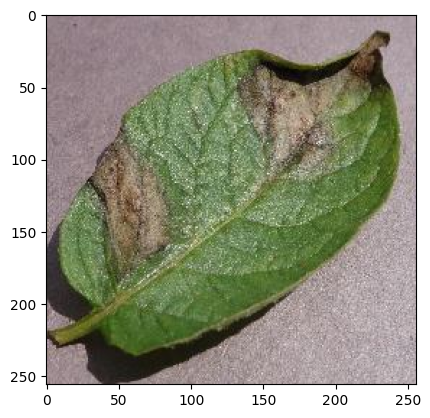

In [52]:
main_img = cv2.imread(test_img_path)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap="Greys_r")

Resize image 

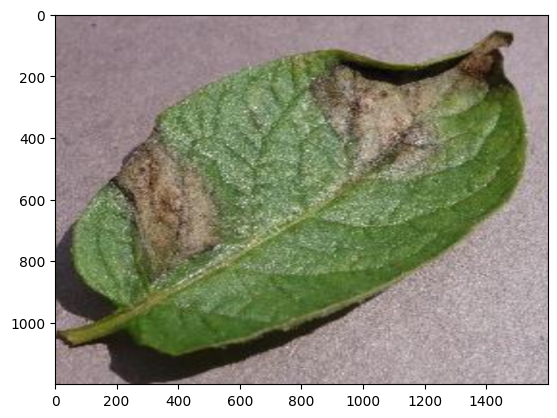

In [53]:
resized_image = cv2.resize(img, (1600, 1200))
plt.imshow(resized_image, cmap="Greys_r")

Enhancing the image so that it will give better result.

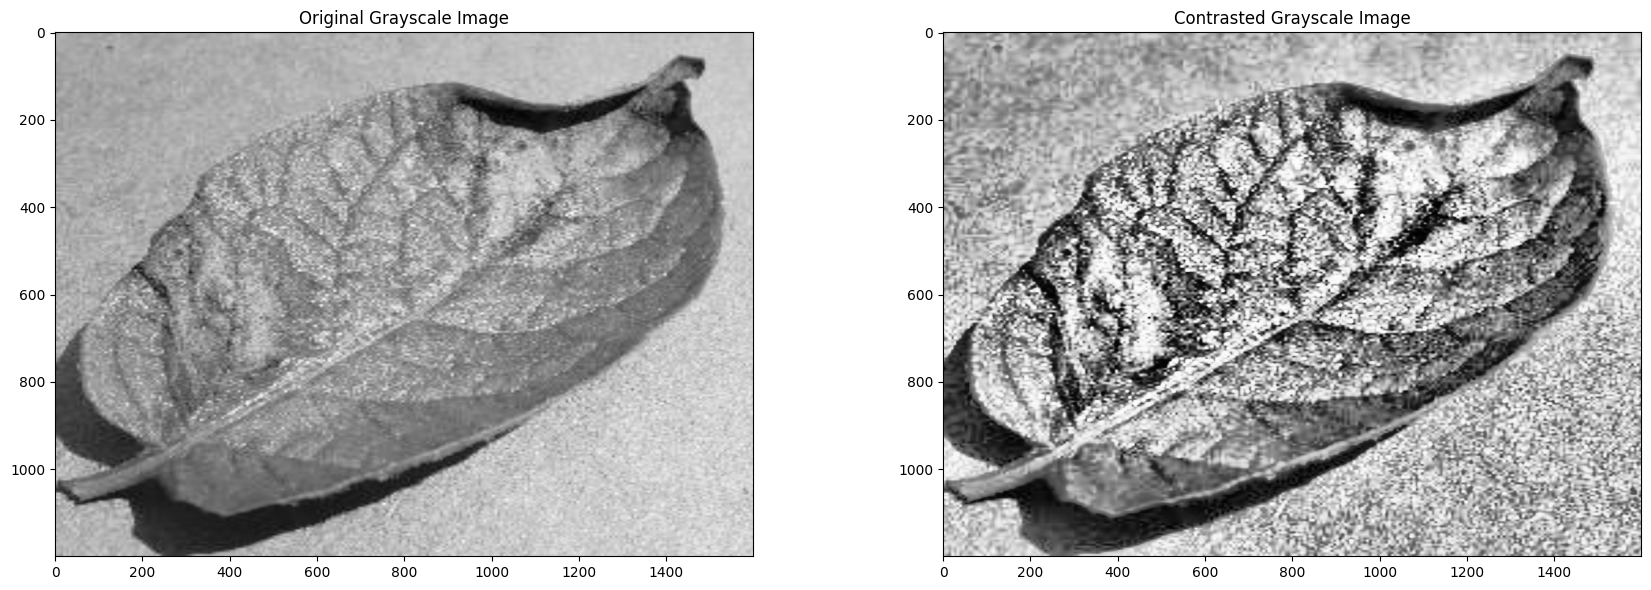

In [54]:
# gray image conversion
gs = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

# Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = exposure.equalize_adapthist(
    gs, kernel_size=None, clip_limit=0.015, nbins=256)

# Convert the float64 image to 8-bit
clahe_uint8 = (clahe * 255).astype(np.uint8)

# Display the original and enhanced images
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(gs, cmap="Greys_r")
plt.title("Original Grayscale Image")

# Adjusting contrast in the enhanced image
contrasted_image = np.clip(clahe_uint8, 0, 255)
plt.subplot(1, 2, 2)
plt.imshow(contrasted_image, cmap="Greys_r")
plt.title("Contrasted Grayscale Image")

plt.tight_layout()
plt.show()

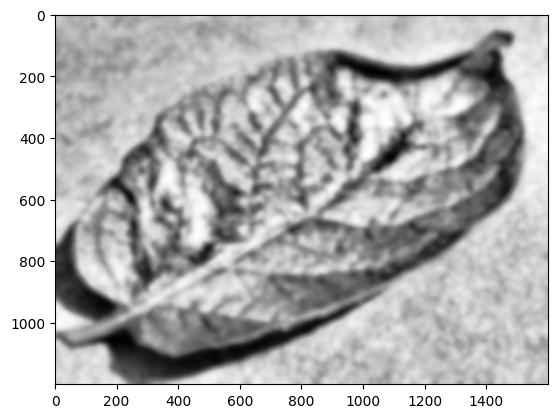

In [55]:
blur = cv2.GaussianBlur(contrasted_image, (55, 55), 0)
plt.imshow(blur, cmap="Greys_r")

Threshold value:  117.0


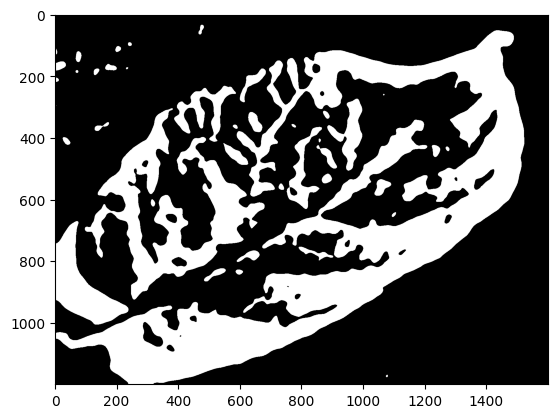

In [56]:
ret_otsu, im_bw_otsu = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu, cmap='Greys_r')
print('Threshold value: ', ret_otsu)

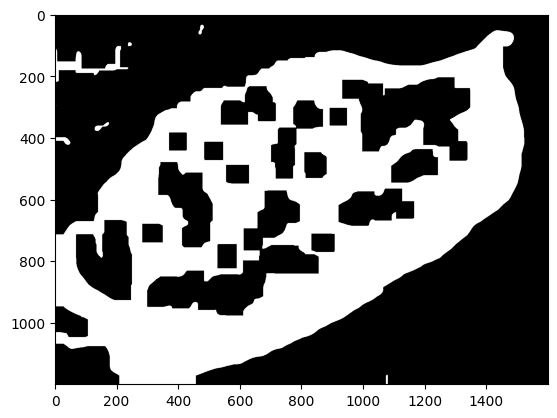

In [66]:
kernel = np.ones((55, 55), np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap="Greys_r")

In [67]:
contours, hierarchyequalize_adapthist = cv2.findContours(
    closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [68]:
len(contours)

24

In [69]:
# Finding the correct leaf contour from the list of contours
def find_contour(cnts):
    contains = []
    y_ri, x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc, (x_ri//2, y_ri//2), False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp > 0]
    print('contains', contains)
    print('val[0]', val[0])
    return val[0]

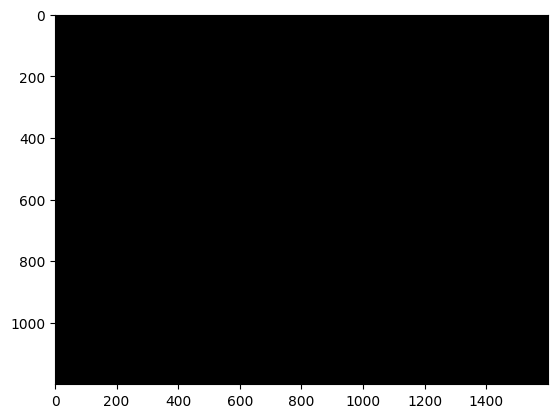

In [70]:
# Creating mask image for background subtraction using leaf contour
black_img = np.empty([1200, 1600, 3], dtype=np.uint8)
black_img.fill(0)
plt.imshow(black_img, cmap="Greys_r")

contains [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
val[0] 6


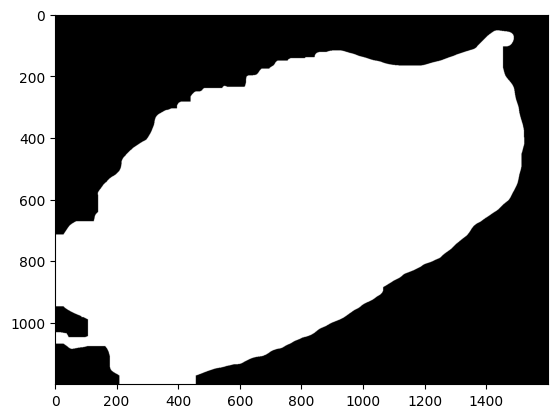

In [71]:
index = find_contour(contours)
cnt = contours[index]
mask = cv2.drawContours(black_img, [cnt], 0, (255, 255, 255), -1)
plt.imshow(mask)

In [72]:
# Performing masking operation on the original image

This is just for representation purpose, in our model we need not to convert the background into white.

In [73]:
maskedImg = cv2.bitwise_and(resized_image, mask)

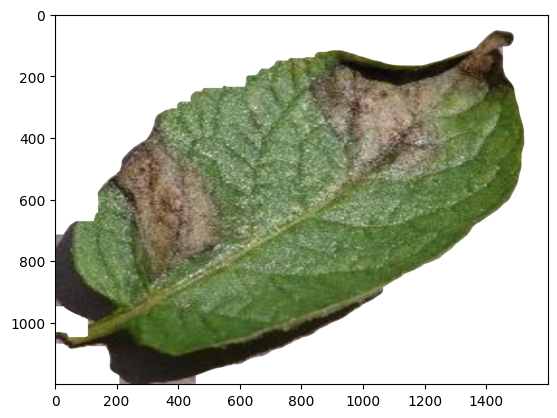

In [74]:
# Create the pixel array
white_pix = np.array([255, 255, 255])
black_pix = np.array([0, 0, 0])

# Create a mask where black pixels are present
mask = np.all(maskedImg == black_pix, axis=-1)

# Replace black pixels with white pixels
maskedImg[mask] = white_pix

plt.imshow(maskedImg)